In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
from functools import partial
import torch
from src.frank_wolfe import pseudo_frank_wolfe, term, isosceles_triangular_extreme_points, approx_step_len
from src.affine_cond_x import objective_template, objective_gradient
from src.affine_cond_x import obj_matrix_form, grad_matrix_form, opt_step_len

In [2]:
budget = 85
xs = torch.randn((2,1))
alpha_init = torch.tensor([[10.0, 10.0]]).T

fn = partial(obj_matrix_form, xs=xs, sigma_sq_k=1, sigma_sq_m=1)
grad_fn = partial(grad_matrix_form, xs=xs, sigma_sq_k=1, sigma_sq_m=1)
extr_point_finder = partial(isosceles_triangular_extreme_points, budget=budget, num_samples=xs.size(0))
step_len_selector = partial(approx_step_len, obj_fn=fn, num_steps=50)
alpha_star, alpha_store = pseudo_frank_wolfe(None, grad_fn, extr_point_finder, step_len_selector, term, alpha_init, num_iter=10)

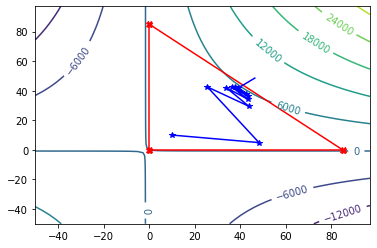

In [3]:
def plot_constraint_set(ax, budget):
    x = np.array([0, budget])
    y = np.array([budget, 0])
    ax.plot(x, y, "r-")
    x = np.array([0, 0])
    y = np.array([0, budget])
    ax.plot(x, y, "r-")
    x = np.array([0, budget])
    y = np.array([0, 0])
    ax.plot(x, y, "r-")
    
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt


delta = 3
alpha_1 = np.arange(-50.0, 100.0, delta)
alpha_2 = np.arange(-50.0, 100.0, delta)
grid_size = alpha_1.shape[0]

# Create meshgrid
X, Y = np.meshgrid(alpha_1, alpha_2)
Z = torch.empty((grid_size, grid_size))
for (i_x, x) in enumerate(alpha_1):
    for (i_y, y) in enumerate(alpha_2):
        alpha = torch.tensor([x, y], dtype=xs.dtype).reshape((2,1))
        Z[i_x, i_y] = fn(alpha)
    
# Contour, constraint set and extr points
fig, ax = plt.subplots()
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=True, fontsize=10)

plot_constraint_set(ax, budget)

extr_points = isosceles_triangular_extreme_points(budget, len(xs))
ax.plot(extr_points[0, :], extr_points[1, :], "rX")

# Traj:
ax.plot(alpha_store[0, :], alpha_store[1, :], "b*-")
# Grad:
grad_star = grad_fn(alpha_star)
g_plot = torch.column_stack((alpha_star, alpha_star + 0.05 * grad_star))
ax.plot(g_plot[0, :], g_plot[1, :], "b-")
lin_star = grad_fn(alpha_star).T @ (extr_points - alpha_star)
opt_extr_init = torch.tensor([[0, budget]]).T

tensor([[41.6327],
        [ 0.0000],
        [ 0.0000],
        [43.3673],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000]])

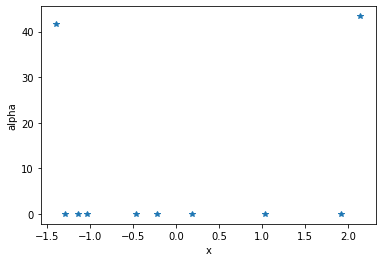

In [6]:
budget = 85
xs = torch.randn((10,1))
alpha_init = torch.zeros(xs.size())

fn = partial(obj_matrix_form, xs=xs, sigma_sq_k=1, sigma_sq_m=1)
grad_fn = partial(grad_matrix_form, xs=xs, sigma_sq_k=1, sigma_sq_m=1)
extr_point_finder = partial(isosceles_triangular_extreme_points, budget=budget, num_samples=xs.size(0))
step_len_selector = partial(approx_step_len, obj_fn=fn, num_steps=50)
alpha_star, alpha_store = pseudo_frank_wolfe(None, grad_fn, extr_point_finder, step_len_selector, term, alpha_init, num_iter=10)

fig, ax = plt.subplots()
ax.plot(xs, alpha_star, '*')
ax.set_xlabel("x")
ax.set_ylabel("alpha")
alpha_star